In [50]:
%pip install -q langchain-core langchain-community langchain-groq langgraph


In [51]:
%pip install -Uq pinecone-client

In [52]:
import os
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.vectorstores import Pinecone
from langchain_community.embeddings import HuggingFaceEmbeddings
from langgraph.checkpoint.memory import MemorySaver  # Import MemorySaver
from langchain_groq import ChatGroq
from typing import List, TypedDict
from langchain_pinecone import PineconeVectorStore


In [ ]:
# Initialize Pinecone
from pinecone import Pinecone as PineconeClient, ServerlessSpec
import os

# Set API keys (ensure this cell is run before the Pinecone initialization)
os.environ["GROQ_API_KEY"] = "api"  # Replace with your Groq API key
os.environ["PINECONE_API_KEY"] = "api"  # Replace with your Pinecone key

pc = PineconeClient(api_key=os.environ["PINECONE_API_KEY"]) # Use the correct environment variable key
index_name = "fitness-goals"


# Initialize Pinecone

In [54]:

from pinecone import Pinecone as PineconeClient
pc = PineconeClient(api_key=os.environ["PINECONE_API_KEY"])
index_name = "fitness-goals"
if index_name not in pc.list_indexes().names():
    pc.create_index(name=index_name, dimension=384, metric="cosine", spec={"serverless": {"cloud": "aws", "region": "us-east-1"}})

In [55]:
%pip install -q langchain-pinecone

In [56]:
import os
from langchain_pinecone import PineconeVectorStore
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq

# Initialize embeddings (no Hugging Face API key needed)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Initialize vector store
memory_store = PineconeVectorStore(index_name=index_name, embedding=embeddings, text_key="text")

# Initialize Groq LLM (LLaMA 3.1 70B)
llm = ChatGroq(model="llama3-70b-8192", api_key=os.environ["GROQ_API_KEY"])

In [57]:


# Define state
class ChatState(TypedDict):
    messages: List
    long_term_memory: List

In [58]:

# Define chatbot node
def chatbot_node(state: ChatState):
    user_input = state["messages"][-1].content
    results = memory_store.similarity_search(user_input, k=1)
    context = results[0].page_content if results else "No prior goals found."
    response = llm.invoke(f"Based on your goal: {user_input} and past context: {context}, recommend a workout.").content
    state["messages"].append(AIMessage(content=response))
    memory_store.add_texts([user_input], metadatas=[{"type": "goal"}])
    return state

In [59]:
from langgraph.checkpoint.memory import MemorySaver

In [60]:
# Build and compile graph
workflow = StateGraph(ChatState)
workflow.add_node("chatbot", chatbot_node)
workflow.set_entry_point("chatbot")
workflow.add_edge("chatbot", END)
graph = workflow.compile(checkpointer=MemorySaver()) # Use MemorySaver

# Run conversation
state = ChatState(messages=[HumanMessage(content="I want to run a marathon.")], long_term_memory=[])

# Define a configuration with a thread_id
config = {"configurable": {"thread_id": "my_unique_thread_id"}} # Replace with a unique ID for each conversation

result = graph.invoke(state, config=config) # Pass the config to invoke
print("Response:", result["messages"][-1].content)

Response: Congratulations on your goal to run a marathon! To help you achieve this, I'll recommend a workout routine that you can follow. Please note that it's essential to consult with a doctor or a running coach before starting any new exercise program.

**Week 1-4: Base Building (Weeks 1-4)**

* Goal: Build your endurance and get your body accustomed to running

* Workout schedule: 3 times a week, with one longer run on the weekends (Sunday)

* Monday (Easy Run):
	+ Warm-up: 10-15 minutes of light jogging or walking
	+ Run at a conversational pace for 20-30 minutes
	+ Cool-down: 10-15 minutes of stretching

* Wednesday (Easy Run):
	+ Warm-up: 10-15 minutes of light jogging or walking
	+ Run at a conversational pace for 20-30 minutes
	+ Cool-down: 10-15 minutes of stretching

* Sunday (Long Run):
	+ Warm-up: 10-15 minutes of light jogging or walking
	+ Run at a conversational pace for 30-40 minutes
	+ Cool-down: 10-15 minutes of stretching

**Week 5-8: Building Endurance (Weeks 5-8)*

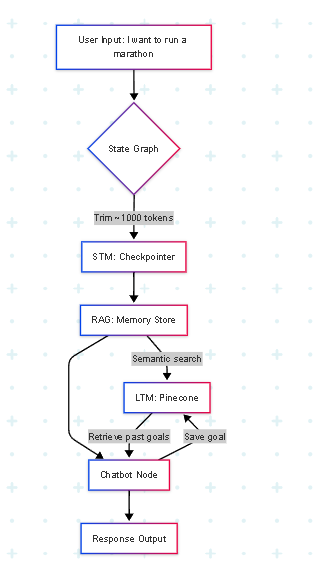